### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

### Problem Definition

Initial Grid World Configuration:


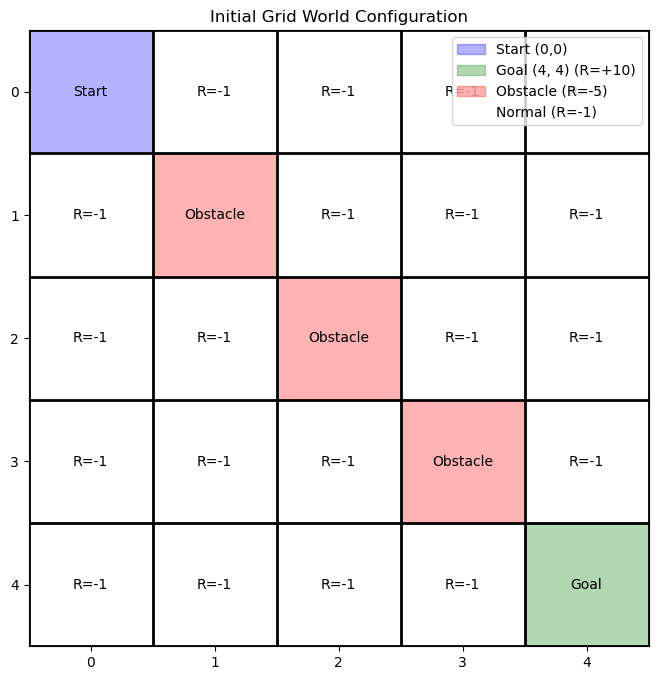

In [5]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.obstacles = [(1,1), (2,2), (3,3)]
        self.actions = ['up', 'down', 'left', 'right']
        self.action_vectors = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }
        
        # Rewards
        self.rewards = np.full((size, size), -1)
        self.rewards[self.goal] = 10
        for obs in self.obstacles:
            self.rewards[obs] = -5
    
    def get_next_state(self, state, action):
        """Get next state with stochastic transitions"""
        # 80% chance of intended action, 20% random other action
        if np.random.random() < 0.8:
            actual_action = action
        else:
            actual_action = np.random.choice([a for a in self.actions if a != action])
        
        row, col = state
        dr, dc = self.action_vectors[actual_action]
        new_row, new_col = row + dr, col + dc
        
        # Check boundaries
        if 0 <= new_row < self.size and 0 <= new_col < self.size:
            return (new_row, new_col)
        return state  # Stay in current state if hits boundary
    
    def get_reward(self, state):
        return self.rewards[state]

def visualize_initial_grid(env):
    """Visualize the initial grid world with rewards and obstacles"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create grid
    for i in range(env.size + 1):
        ax.axhline(i, color='black', lw=2)
        ax.axvline(i, color='black', lw=2)
    
    # Set axis limits
    ax.set_xlim(0, env.size)
    ax.set_ylim(0, env.size)
    ax.invert_yaxis()  # So (0,0) is top-left
    
    # Add labels
    ax.set_xticks(np.arange(env.size) + 0.5)
    ax.set_yticks(np.arange(env.size) + 0.5)
    ax.set_xticklabels(np.arange(env.size))
    ax.set_yticklabels(np.arange(env.size))
    ax.set_title('Initial Grid World Configuration')
    
    # Color cells
    for i in range(env.size):
        for j in range(env.size):
            state = (i, j)
            if state == env.start:
                color = 'blue'
                text = "Start"
            elif state == env.goal:
                color = 'green'
                text = "Goal"
            elif state in env.obstacles:
                color = 'red'
                text = "Obstacle"
            else:
                color = 'white'
                text = f"R={env.rewards[i,j]}"
            
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, alpha=0.3))
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', fontsize=10)
    
    # Legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, color='blue', alpha=0.3, label='Start (0,0)'),
        plt.Rectangle((0,0),1,1, color='green', alpha=0.3, label=f'Goal {env.goal} (R=+10)'),
        plt.Rectangle((0,0),1,1, color='red', alpha=0.3, label='Obstacle (R=-5)'),
        plt.Rectangle((0,0),1,1, color='white', alpha=0.3, label='Normal (R=-1)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.show()

# Create and visualize environment
env = GridWorld()
print("Initial Grid World Configuration:")
visualize_initial_grid(env)

### Q-Learning

In [15]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1):
    """Q-learning algorithm"""
    # Initialize Q-table with zeros
    Q = np.zeros((env.size, env.size, len(env.actions)))
    action_index = {a: i for i, a in enumerate(env.actions)}
    
    # Track rewards per episode
    episode_rewards = []
    
    for episode in range(episodes):
        state = env.start
        total_reward = 0
        done = False
        
        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.choice(env.actions)
            else:
                action_idx = np.argmax(Q[state[0], state[1]])
                action = env.actions[action_idx]
            
            # Take action
            next_state = env.get_next_state(state, action)
            reward = env.get_reward(next_state)
            total_reward += reward
            
            # Q-learning update
            current_q = Q[state[0], state[1], action_index[action]]
            max_next_q = np.max(Q[next_state[0], next_state[1]])
            
            # Update rule: Q(s,a) ← Q(s,a) + α[r + γmaxQ(s',a') - Q(s,a)]
            Q[state[0], state[1], action_index[action]] = (
                current_q + alpha * (reward + gamma * max_next_q - current_q)
            )
            
            # Check if episode ended
            if next_state == env.goal:
                done = True
            
            state = next_state
        
        episode_rewards.append(total_reward)
    
    return Q, episode_rewards

def visualize_q_table(Q, env):
    """Visualize Q-table as arrows in the grid"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create grid
    for i in range(env.size + 1):
        ax.axhline(i, color='black', lw=2)
        ax.axvline(i, color='black', lw=2)
    
    # Set axis limits
    ax.set_xlim(0, env.size)
    ax.set_ylim(0, env.size)
    ax.invert_yaxis()  # So (0,0) is top-left
    
    # Add labels
    ax.set_xticks(np.arange(env.size) + 0.5)
    ax.set_yticks(np.arange(env.size) + 0.5)
    ax.set_xticklabels(np.arange(env.size))
    ax.set_yticklabels(np.arange(env.size))
    ax.set_title('Q-table Visualization (Best Actions)')
    
    # Plot obstacles and goal
    for obs in env.obstacles:
        ax.add_patch(plt.Rectangle(obs, 1, 1, color='red', alpha=0.3))
    ax.add_patch(plt.Rectangle(env.goal, 1, 1, color='green', alpha=0.3))
    
    # Plot start
    ax.add_patch(plt.Rectangle(env.start, 1, 1, color='blue', alpha=0.3))
    
    # Plot arrows for best actions
    arrow_length = 0.4
    for i in range(env.size):
        for j in range(env.size):
            if (i,j) == env.goal or (i,j) in env.obstacles:
                continue
            
            best_action_idx = np.argmax(Q[i,j])
            best_action = env.actions[best_action_idx]
            
            di, dj = env.action_vectors[best_action]
            ax.arrow(j + 0.5, i + 0.5, 
                     dj * arrow_length, di * arrow_length, 
                     head_width=0.2, head_length=0.2, fc='k', ec='k')
    
    plt.show()

def plot_learning_curve(rewards, window=50):
    """Plot rewards over episodes with moving average"""
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, alpha=0.3, label='Episode Reward')
    plt.plot(np.arange(window-1, len(rewards)), moving_avg, label=f'{window}-Episode Moving Avg')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-learning Performance')
    plt.legend()
    plt.grid()
    plt.show()

### Running And Showing Result

Running Q-learning...

Q-table visualization (best actions):


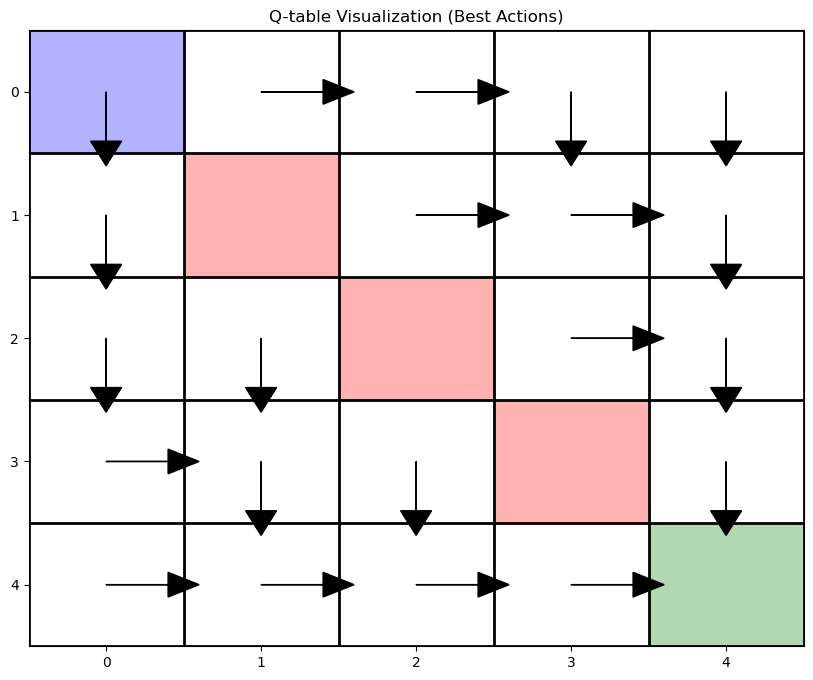


Learning curve:


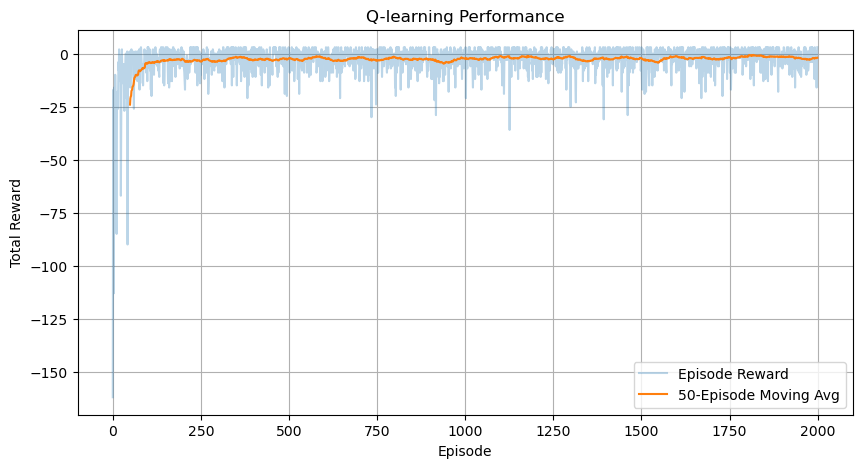


Optimal path from start to goal:
(0,0) -> (0,0) -> (1,0) -> (2,0) -> (2,1) -> (2,0) -> (3,0) -> (2,0) -> (3,0) -> (3,1) -> (4,1) -> (4,2) -> (4,3) -> (4,3) -> (4,4)


In [13]:
# Main execution
if __name__ == "__main__":
    # Create environment
    env = GridWorld()
    
    # Run Q-learning
    print("Running Q-learning...")
    Q, rewards = q_learning(env, episodes=2000)
    
    # Visualizations
    print("\nQ-table visualization (best actions):")
    visualize_q_table(Q, env)
    
    print("\nLearning curve:")
    plot_learning_curve(rewards)
    
    # Print optimal path
    print("\nOptimal path from start to goal:")
    state = env.start
    path = [state]
    while state != env.goal:
        action_idx = np.argmax(Q[state[0], state[1]])
        action = env.actions[action_idx]
        state = env.get_next_state(state, action)
        path.append(state)
    print(" -> ".join([f"({r},{c})" for (r,c) in path]))